In [1]:
import pydicom
import numpy
import numpy as np
import cv2
import os
import math
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

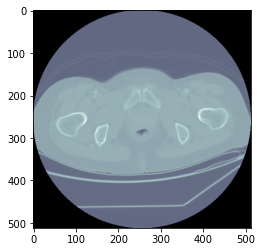

In [2]:
filename = '/storage/home/ppk5143/DS440/DS_440_Capstone/volume/data/raw/Images/6/00000021.dcm'
ds = pydicom.dcmread(filename)
img = plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

In [3]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [4]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80) #bone windowing
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * brain_image
    return masked_image

In [5]:
remove_noise(filename, display=True)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
iskemiMaskedImg = remove_noise(filename, display=True)

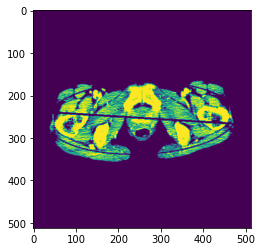

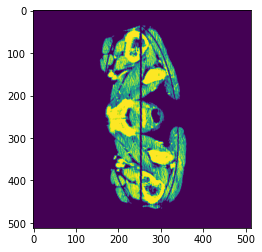

In [7]:
img=numpy.uint8(iskemiMaskedImg)
contours, hier =cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask=numpy.zeros(img.shape, numpy.uint8)

# find the biggest contour (c) by the area
c = max(contours, key = cv2.contourArea)

(x,y),(MA,ma),angle = cv2.fitEllipse(c)

cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

rmajor = max(MA,ma)/2
if angle > 90:
    angle -= 90
else:
    angle += 96
xtop = x + math.cos(math.radians(angle))*rmajor
ytop = y + math.sin(math.radians(angle))*rmajor
xbot = x + math.cos(math.radians(angle+180))*rmajor
ybot = y + math.sin(math.radians(angle+180))*rmajor
cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

pylab.imshow(img)
pylab.show()

M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

pylab.imshow(img)
pylab.show()

In [9]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image

In [10]:
croppedImage = crop_image(img)

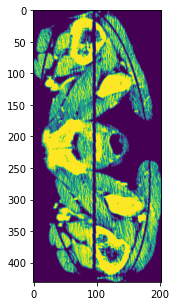

In [11]:
plt.figure(figsize=(15, 5))
plt.imshow(croppedImage)

In [12]:
croppedImage.shape

(431, 203)

In [13]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

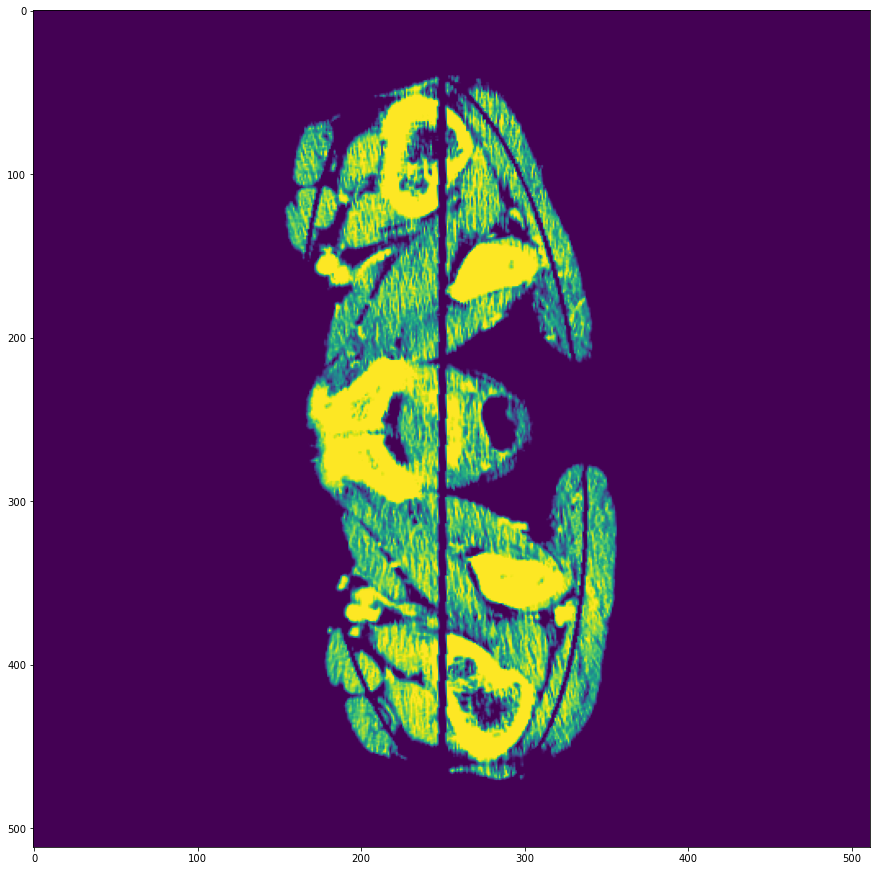

In [14]:
plt.figure(figsize=(15, 25))
final_image = add_pad(croppedImage)
plt.imshow(final_image)

In [15]:
new_name = "Processed3-2.png"
folder_name = '/storage/home/ppk5143/DS440/DS_440_Capstone/volume/data/interim/'
cv2.imwrite(os.path.join(folder_name,new_name),img*3)

True

True